In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sequence.kernel.timeline import Timeline
from sequence.components.photon import Photon
from sequence.utils.encoding import polarization
from sequence.components.polarization_analyzer import PolarizationAnalyzer  # Replace with actual import
from numpy import sqrt
from sequence.components.spdc_source_node import SpdcSourceNode
from sequence.topology.node import Node
from sequence.components.optical_channel import QuantumChannel
from numpy import radians

In [6]:
def count_coincidences(tA, tB, window=1e3):
    ta = np.sort(np.array(tA))
    tb = np.sort(np.array(tB))
    a_idx = b_idx = count = 0
    while a_idx < len(ta) and b_idx < len(tb):
        diff = ta[a_idx] - tb[b_idx]
        if abs(diff) <= window:
            count += 1
            a_idx += 1
            b_idx += 1
        elif diff < -window:
            a_idx += 1
        else:
            b_idx += 1
    return count

def test_polarization_analyzer_coincidences(angle_rad_A, angle_rad_B, num_pulses=100000):
    tl = Timeline()
    # Setup source
    source = SpdcSourceNode("source", tl, config={
        "frequency": 1e6,
        "mean_photon_num": 0.1,
        "bell_state": "psi+",
    })

    # Two analyzers with configurable HWP angles
    analyzer_A = PolarizationAnalyzer("analyzer_A", tl, angle=angle_rad_A, which="signal")
    analyzer_B = PolarizationAnalyzer("analyzer_B", tl, angle=angle_rad_B, which="idler")

    # Quantum channels
    qc_A = QuantumChannel("qc_A", tl, distance=1e5, attenuation=0)
    qc_B = QuantumChannel("qc_B", tl, distance=1e5, attenuation=0)
    qc_A.set_ends(source, analyzer_A.name)
    qc_B.set_ends(source, analyzer_B.name)
    

    # Run
    tl.init()
    source.spdc.emit(num_pulses=num_pulses)
    tl.run()

    counts_A = analyzer_A.get_detection_counts()
    counts_B = analyzer_B.get_detection_counts()

    hh = count_coincidences(counts_A[0], counts_B[0])
    #vv = count_coincidences(counts_A[1], counts_B[1])
    return hh 




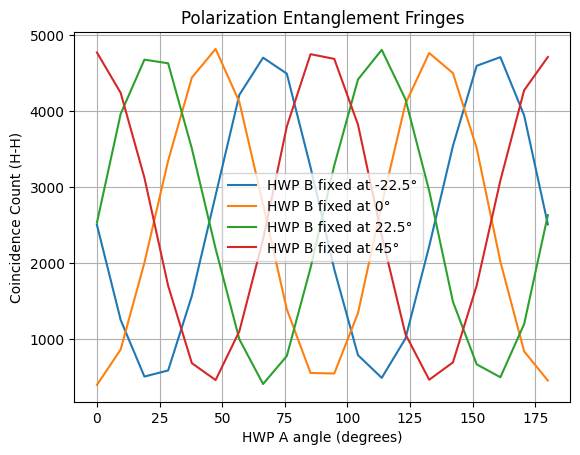

In [8]:
angles = np.linspace(0, np.pi , 20)

fixed_angles = [-22.5, 0, 22.5, 45]
coincidences = []
results = {f"{angle}°": [] for angle in fixed_angles}
for fixed in fixed_angles:
    fixed_rad = radians(fixed)
    for angle in angles:
        c = test_polarization_analyzer_coincidences(angle, fixed_rad)  # Fix B, rotate A
        coincidences.append(c)
    results[f"{fixed}°"].append(coincidences)
    coincidences = []  # Reset for next fixed angle


# === Plot ===
for label, data in results.items():

    plt.plot(np.degrees(angles), data[0], label=f"HWP B fixed at {label}")

plt.xlabel("HWP A angle (degrees)")
plt.ylabel("Coincidence Count (H-H)")
plt.title("Polarization Entanglement Fringes")
plt.grid(True)
plt.legend()
plt.show()






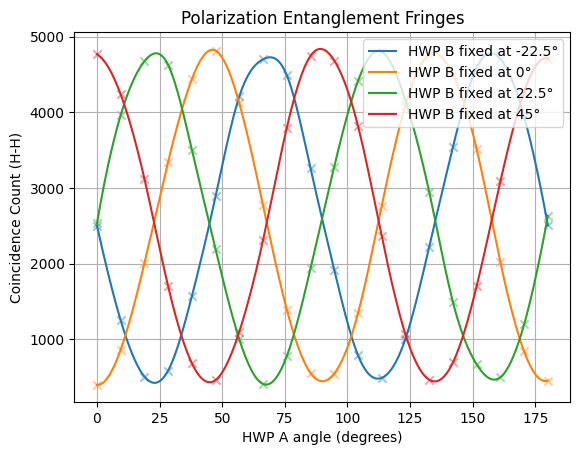

In [12]:
from scipy.interpolate import make_interp_spline

# === Plot ===
for label, data in results.items():
    x = np.degrees(angles)
    y = data[0]

    # Interpolate
    x_smooth = np.linspace(x.min(), x.max(), 500)  # More points
    spline = make_interp_spline(x, y, k=3)         # Cubic spline
    y_smooth = spline(x_smooth)

    # Plot smooth curve
    plt.plot(x_smooth, y_smooth, label=f"HWP B fixed at {label}")
    plt.scatter(x, y, marker='x', alpha=0.4)  # Optional: show original points faintly

plt.xlabel("HWP A angle (degrees)")
plt.ylabel("Coincidence Count (H-H)")
plt.title("Polarization Entanglement Fringes")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
